# Diabetes project

In [368]:
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

## 1.1 Read SPSS databaseabs

In [369]:
df_spss = pd.read_spss("DIALECT-1 + 2. definitief ruwe database (08-2019) met exclusie van dialect-1 patienten (n=671)_2.sav")


In [370]:
df_spss

,Subjectnr,Geslacht,Leeftijd_poli1,Polidatum1,Polijaar_1,Polibezoek,Arts,Freq_arts,Freq_vp,Freq_tot,...,SumOfvite,SumOfrae,SumOffole,SumOfzink,SumOfdpa,SumOfarachidonz,SumOffolaat,SumOfnico,SumOfwater,SumOfnatrium
0,1.0,man,65.0,2009-08-31,2009.0,Eerste bezoek,Schot,4.0,0.0,4.0,...,13.267616,602.510257,173.289978,9.203426,0.000000,0.034463,173.289978,16.178387,1591.211480,2607.443336
1,2.0,man,61.0,2009-08-31,2009.0,Eerste bezoek,Oving,1.0,4.0,5.0,...,10.662237,645.575531,133.897548,7.454809,0.000010,0.047574,133.897548,16.796363,2216.603139,1891.477166
2,3.0,man,56.0,2009-08-31,2009.0,Eerste bezoek,Veneman,0.0,0.0,0.0,...,29.996976,1207.776682,209.312323,13.193616,0.000494,0.031634,205.339877,22.143815,2758.233627,3351.952037
3,4.0,vrouw,51.0,2009-08-31,2009.0,Eerste bezoek,Ouwehand,1.0,4.0,5.0,...,4.281328,218.128055,90.296190,5.820861,0.000057,0.039529,90.296190,5.644264,673.484131,1646.457431
4,5.0,vrouw,60.0,2009-08-31,2009.0,Eerste bezoek,van Zanten,1.0,4.0,5.0,...,16.653028,1482.346823,207.709797,10.275772,0.000243,0.079542,207.709797,18.294950,2028.428955,2972.889884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,732.0,vrouw,74.0,2019-05-22,2019.0,Eerste bezoek,van berkum,3.0,1.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
668,733.0,vrouw,28.0,2019-04-26,2019.0,Eerste bezoek,Visser,7.0,24.0,31.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
669,734.0,man,65.0,2019-05-08,2019.0,Eerste bezoek,de Vries,5.0,8.0,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
670,736.0,man,77.0,2019-05-22,2019.0,Eerste bezoek,Laverman,4.0,2.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 1.2 Read Excel files

In [371]:
def read_recursively(path: str) -> list:
    """Read the data for each one of the folder """
    paths = list(Path(path).iterdir())
    paths.sort()
    return {k: df for k, df in [process_folder(p) for p in paths]}


def process_folder(dir: Path) -> list:
    """Read the files from each folder"""
    path_name = dir / f"{dir.name}-steps.xlsx"
    if path_name.exists():
        df = pd.read_excel(path_name)
    else:
        df = None
    return dir.name, df

In [372]:
time_series = read_recursively("Diabetes")
time_series.keys()

dict_keys(['353', '364', '369', '371', '380', '458', '466', '470', '471', '473', '476', '477', '479', '480', '482', '483', '485', '486', '487', '488', '489', '490'])

In [373]:
df_353 = time_series['353']
df_353
df_353.columns

Index(['time', '2017-01-13', '2017-01-14', '2017-01-15', '2017-01-16',
       '2017-01-17', '2017-01-18', '2017-01-19', '2017-01-20'],
      dtype='object')

# 2 Features

* [x] Geslacht => new column called "Gender"
* [x] Leeftijd_poli1
* [x] Freq_tot
* [x] DMduur = polijaar_1 – Dmaanvang
* [x] Pack_years
* [x] Alcoholgebruik1EHpermaand
* [x] Lengte_poli1
* [x] Gewicht_poli1
* [x] Buikomvang_1
* [x] Heupomvang_1
* [ ] SBP_poli1
* [ ] DBP_poli1
* [ ] Pols
* [x] Microvas_total (INPUT OR OUTPUT)
* [x] Macrovasculaire_ziekten (INPUT OR OUTPUT)
* [x] SerumHbA1c_1 (INPUT OR OUTPUT)
* [x] Serum_cholesterol_1
* [x] Total_number_drugs
* [x] Total_EH_Insulin = dosA10AB + dosA10AC + dosA10AD + dosA10AE. If there is no outcome (NaN), it should be filled in with 0.



## 3 Clean the dataframes

In [374]:
def replace_with_mean_if_nan(df: pd.DataFrame, columns: list, max_nan: int = 50) -> pd:
    """Iterate over the columns of the dataframe and replace the nan values with the mean"""
    df_ml = pd.DataFrame()
    for c in columns:
        nas = df[c].isna().any().sum()
        if nas > max_nan:
            raise RuntimeError(f"Column {c} has more than {max_nan} NaN values!")
        elif df[c].isna().any():    
            df_ml[c] = df[c].fillna(df[c].mean())
        else:
            df_ml[c] = df[c]
    return df_ml

### 3.1 copy data to new DataFrame

In [391]:
features = ["Leeftijd_poli1", "Freq_tot", "Pack_years", "Alcoholgebruik1EHpermaand", "Lengte_poli1","Gewicht_poli1", "Buikomvang_1", "Heupomvang_1", "Serum_cholesterol_1",
            "SerumHbA1c_1", "Total_number_drugs", "Microvas_total"]


In [392]:

properties = df_spss[features]
properties[properties.isna().sum(axis=1) > 3].size

24

Copy features to an empty DataFrame

In [393]:
df_ml = replace_with_mean_if_nan(df_spss, features)

Skip patients with More than 3 Nan in their features

In [394]:
df_ml = df_ml[properties.isna().sum(axis=1) <= 3]

### 3.2 Clean  columns

In [395]:
df_ml["Gender"] = df_spss["Geslacht"].apply(lambda x: 0.0 if x == "man" else 1.0)

In [396]:
 df_ml["DMduur"] = df_spss["Polijaar_1"] - df_spss["DMaanvang"]

In [397]:
df_ml["Total_EH_Insulin"] = df_spss["dosA10AB"].fillna(0) + df_spss["dosA10AC"].fillna(0) + df_spss["dosA10AD"].fillna(0) + df_spss["dosA10AE"].fillna(0)

In [398]:
df_ml["Macrovasculaire_ziekten"] = df_spss["Macrovasculaire_ziekten"].apply(lambda x: 0.0 if x == "nee" else 1.0)

In [400]:
df_ml["SBP"] = df_spss[['SBP1', 'SBP2', 'SBP3']].mean(axis=1)
df_ml["SBP"] = df_ml["SBP"].fillna(df_ml["SBP"].mean())

In [401]:
df_ml["DBP"] = df_spss[['DBP1', 'DBP2', 'DBP3']].mean(axis=1)
df_ml["DBP"] = df_ml["DBP"].fillna(df_ml["SBP"].mean())

## 4 Visualize the Data

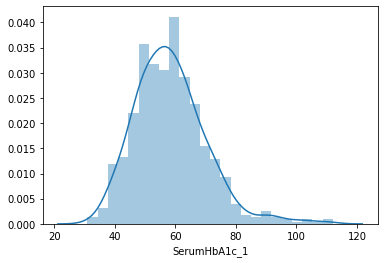

In [402]:
sns.distplot(df_ml["SerumHbA1c_1"])

In [403]:
df_ml["Microvas_total"][ df_ml["Microvas_total"] == 0.0].size

444

In [406]:
df_ml["Macrovasculaire_ziekten"][df_ml["Macrovasculaire_ziekten"] == 0.0].size

429

## 5 Normalize Data

In [388]:
arr = df_ml.to_numpy()

In [389]:
>>> from sklearn.preprocessing import Normalizer
transformer = Normalizer()
transformer.transform(arr)

array([[0.17294386, 0.0106427 , 0.29001354, ..., 0.00266067, 0.35453134,
        0.35453134],
       [0.16720865, 0.01370563, 0.1726909 , ..., 0.00274113, 0.36525128,
        0.36525128],
       [0.17077082, 0.        , 0.12807811, ..., 0.00304948, 0.40633897,
        0.40633897],
       ...,
       [0.19749523, 0.03949905, 0.03646066, ..., 0.00303839, 0.40815681,
        0.21268717],
       [0.22515361, 0.01754444, 0.        , ..., 0.00292407, 0.35186344,
        0.16277339],
       [0.21311169, 0.03088575, 0.0370629 , ..., 0.00308858, 0.46122723,
        0.24296792]])

## 6 Explore some Regression/Classification model

In [407]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.
